In [1]:
# Last mod: FA 2024 Sep 8 for Coimbra workshop

# XGBoost regression example
## Predicting stellar ages from spectroscopic abundances

This notebook is based on the [code](https://github.com/fjaellet/xgboost_chem_ages) associated with [Anders+2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...678A.158A/abstract). 

We present an example of a ML regression task: **given** spectroscopic measurements of **stellar parameters** (effective temperature, surface gravity) and **element abundance ratios** ([Fe/H], [Mg/Fe], etc.) measured by the APOGEE survey, we want to **predict the age** of (giant) stars.

This idea is sometimes referred to as chemical clocks.

The **training set** is coming from the APOGEE-Kepler dataset of [Miglio+2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract): Kepler gives us extremely precise lightcurves --> power spectra show solar-like oscillations --> stellar masses and radii --> ages.


In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import colors

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from scipy.stats import gaussian_kde
from scipy.interpolate import make_interp_spline

import os.path

from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import xgboost as xgb
#import shap

from itertools import product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# from utils import running_median, overplot_trend

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 
font = {'family' : 'serif', 'serif': 'helvet', 'weight' : 'bold', 'size'   : 20}
mpl.rc('font', **font)
mpl.rc('text', usetex=True)

In [3]:
xgb.__version__

'1.7.6'

# Import the training table (APOGEE-Kepler dataset)

We use the table containing asteroseismic+spectroscopic age estimates from [Miglio et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) - already crossmatched with APOGEE DR17:

In [4]:
miglio2021 = Table.read("./data/Miglio2021_X_APOGEE_DR17.fits")
names = [name for name in miglio2021.colnames if len(miglio2021[name].shape) <= 1]
miglio2021.keep_columns(names)
mig = miglio2021.to_pandas()
mig.head()

,APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'2M19222920+3710285',1569842,9.589,9.074,8.989,290.6217,37.174599,-0.24,0.12,9.8,...,0.012334,0,NaN,NaN,0.005112,2,0.096240,0.151900,0.069591,0
1,b'2M19300513+3717470',1726291,11.206,10.679,10.547,292.5214,37.296398,-0.34,0.19,10.1,...,0.015864,0,NaN,NaN,0.009413,2,-0.318970,-0.263310,0.085400,0
2,b'2M19045380+3741230',2283721,11.266,10.709,10.590,286.2242,37.689701,-0.19,0.11,9.4,...,0.014437,0,NaN,NaN,NaN,259,0.116419,0.172079,0.077468,0
3,b'2M19060736+3740100',2284679,9.923,9.456,9.335,286.5307,37.669399,-0.45,0.21,11.2,...,0.014171,0,NaN,NaN,0.010622,2,-0.313170,-0.257510,0.076819,0
4,b'2M19280882+3736381',2305590,9.829,9.235,9.128,292.0368,37.610600,-0.30,0.24,10.2,...,0.018914,0,NaN,NaN,0.009991,258,0.581840,0.637500,0.082008,0


In [5]:
list(mig.columns)

['APOGEE',
 'KIC',
 'Jmag',
 'Hmag',
 'Ksmag',
 'RAdeg',
 'DEdeg',
 '__Fe_H_',
 '__alpha_M_',
 'Age',
 'b_Age',
 'b_age_lc',
 'Mass',
 'b_Mass',
 'b_mass_lc',
 'Rad',
 'b_Rad',
 'b_rad_lc',
 'Dist',
 'b_Dist',
 'b_dist_lc',
 'Av',
 'b_Av',
 'b_av_lc',
 'evstate',
 'zmax',
 'e_zmax',
 'Ecc',
 'e_Ecc',
 'Rperi',
 'e_Rperi',
 'Rap',
 'e_Rap',
 'GalR',
 'Galphi',
 'GalZ',
 'vR',
 'vT',
 'vZ',
 '_RA',
 '_DE',
 'APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'ALT_ID',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'AK_TARG',
 'AK_TARG_METHOD',
 'AK_WISE',
 'SFD_EBV',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'APOGEE2_TARGET4',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NVISITS',
 'SNR',
 'SNREV',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CHI2',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'RV_FLAG',
 'N_COMPONENTS'

We'll also have a look at the APOGEE DR17 abundance flags:

## Inspect the table and make some plots 

### Evolutionary stage of the stars

There is a column informing about the evolutionary state (RC / RGB):

In [6]:
print("RGB stars:", np.sum(mig['evstate']==1))
print("RC  stars:", np.sum(mig['evstate']==2))
print("other:", np.sum((mig['evstate']!=1) & (mig['evstate']!=2)))

RGB stars: 2428
RC  stars: 887
other: 0


### $T_{\rm eff}-\log g$ diagram

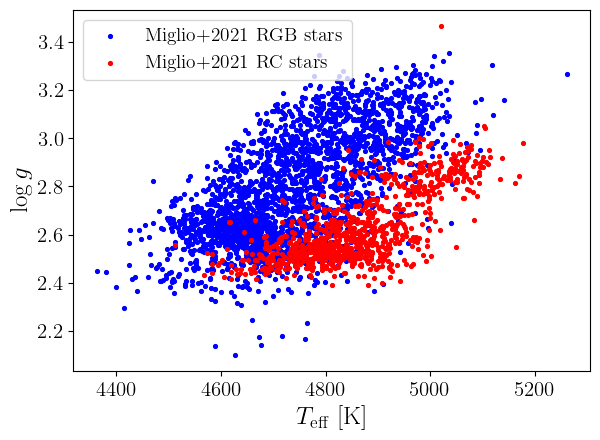

In [7]:
rgb = (mig['evstate']==1)
rc  = (mig['evstate']==2)

plt.scatter(mig['TEFF'][rgb], mig['LOGG'][rgb], s=7.5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['TEFF'][rc],  mig['LOGG'][rc],  s=7.5, c="red", label="Miglio+2021 RC stars")
plt.xlabel(r"$T_{\rm eff}$ [K]", fontsize=18)
plt.ylabel(r"$\log g$", fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.tight_layout()

### Age uncertainties

Median rel. age uncertainty for RGB: 0.22727273
Median rel. age uncertainty for RC: 0.097561


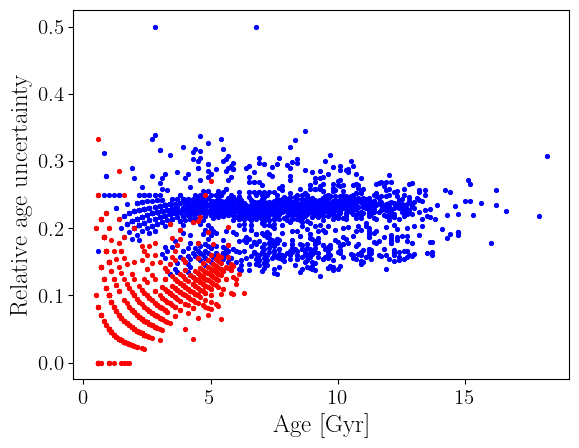

In [8]:
x = mig['Age']
y = 0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"]

plt.scatter(x[rgb],y[rgb], c="b", s=7.5)
plt.scatter(x[rc], y[rc],  c="r", s=7.5)

plt.xlabel(r"Age [Gyr]", fontsize=18)
plt.ylabel(r"Relative age uncertainty", fontsize=18)

print("Median rel. age uncertainty for RGB:", np.nanmedian(y[rgb]))
print("Median rel. age uncertainty for RC:", np.nanmedian(y[rc]))
      

### Galactic distribution

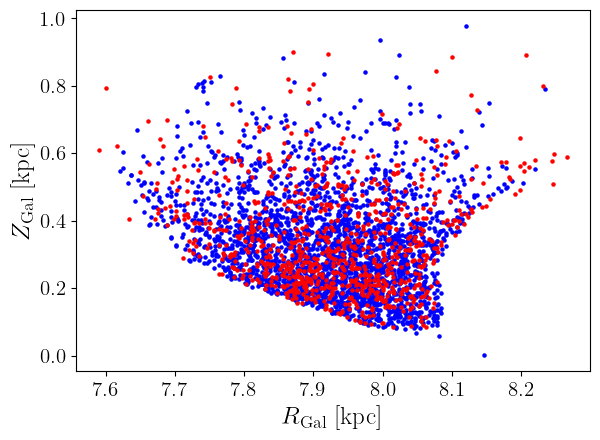

In [9]:
plt.scatter(mig['GalR'][rgb], mig['GalZ'][rgb], s=5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['GalR'][rc],  mig['GalZ'][rc],  s=5, c="red", label="Miglio+2021 RC stars")
plt.xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
plt.ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)
plt.tight_layout()

### APOGEE abundance flags

In [10]:
for columns in mig:
    if columns.endswith("_FLAG"):
        print(columns)
        print(mig[str(columns)].value_counts())
        print()

RV_FLAG
0     3314
32       1
Name: RV_FLAG, dtype: int64

C_FE_FLAG
0      3314
256       1
Name: C_FE_FLAG, dtype: int64

CI_FE_FLAG
0      3312
256       3
Name: CI_FE_FLAG, dtype: int64

N_FE_FLAG
0      3272
256      37
288       6
Name: N_FE_FLAG, dtype: int64

O_FE_FLAG
0    3315
Name: O_FE_FLAG, dtype: int64

NA_FE_FLAG
0      3311
256       3
1         1
Name: NA_FE_FLAG, dtype: int64

MG_FE_FLAG
0    3315
Name: MG_FE_FLAG, dtype: int64

AL_FE_FLAG
0    3315
Name: AL_FE_FLAG, dtype: int64

SI_FE_FLAG
0    3315
Name: SI_FE_FLAG, dtype: int64

P_FE_FLAG
2      3270
258      30
0         8
3         4
259       3
Name: P_FE_FLAG, dtype: int64

S_FE_FLAG
0      3314
256       1
Name: S_FE_FLAG, dtype: int64

K_FE_FLAG
0      3313
1         1
256       1
Name: K_FE_FLAG, dtype: int64

CA_FE_FLAG
0    3315
Name: CA_FE_FLAG, dtype: int64

TI_FE_FLAG
0    3315
Name: TI_FE_FLAG, dtype: int64

TIII_FE_FLAG
0      3307
257       4
256       3
1         1
Name: TIII_FE_FLAG, dtype: int64


# Create the actual training set

### Define high-quality criteria

We don't want the ML algorithm to learn junk. 
On the other hand, we need a large enough training set..  so we have to define a number of (ideally physically motivated) quality criteria. 

For example, looking at the FLAG values above, we may decide not to use [P/Fe] and [Cu/Fe].
For all other abundances, we require the corresponding FLAG to equal zero:

In [11]:
mig = mig[(mig['RV_FLAG'] == 0)   & (mig['C_FE_FLAG'] == 0)   & \
          (mig['CI_FE_FLAG'] == 0)& (mig['N_FE_FLAG'] == 0)   & \
          (mig['O_FE_FLAG'] == 0) & (mig['NA_FE_FLAG'] == 0)  & \
          (mig['S_FE_FLAG'] == 0) & (mig['TI_FE_FLAG'] == 0)  & \
          (mig['V_FE_FLAG'] == 0) & (mig['CE_FE_FLAG'] == 0)  & \
          (mig['SNREV'] >= 70) & \
          (0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"] < 0.3) & \
          (0.5 * (mig['b_age_lc'] - mig['b_Age']) < 3) & \
          (mig["Age"] > 0)    & (mig["Age"] < 15) & \
          (mig["ALPHA_M"] < 0.14 + 0.0001*(mig["Age"] - 4.1)**5)
         ]

print(len(mig), "suffice the FLAG conditions")

3060 suffice the FLAG conditions


Now we create a pandas dataframe containing only the columns we think could be interesting to use in the training:

In [12]:
trainfeatures = ['TEFF', 'LOGG', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 
                 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'K_FE', 
                 'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'CE_FE']
filtered_df = mig[['Age'] + trainfeatures].copy() # excluding: ['FE_H']
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')

In [13]:
filtered_df.head()

,Age,TEFF,LOGG,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,K_FE,CA_FE,TI_FE,V_FE,MN_FE,CO_FE,NI_FE,CE_FE
0,9.8,4817.990723,3.083905,0.071996,0.076009,0.073346,0.196913,-0.129988,0.223263,0.188314,0.134081,0.235769,0.094765,0.179623,-0.042288,-0.101498,0.09864,0.107133,0.096240
1,10.1,4823.796387,3.109932,0.070293,0.194000,0.115990,0.314393,-0.352128,0.348673,0.259540,0.198561,0.302629,0.190765,0.151823,0.250612,-0.122728,0.13715,0.110182,-0.318970
2,9.4,4748.026855,2.788529,0.065446,0.029532,0.086760,0.180403,0.009112,0.186943,0.195936,0.124651,0.368155,0.109715,0.109363,-0.187218,-0.096728,0.11898,0.042022,0.116419
3,11.2,4889.548828,3.245908,0.102185,0.198900,0.009152,0.328173,0.068522,0.361593,0.247761,0.191911,0.361549,0.191585,0.183673,-0.175608,-0.144048,0.08713,0.081733,-0.313170
4,10.2,4605.007812,2.480893,0.166720,0.234920,0.034750,0.282853,0.043942,0.394983,0.272437,0.166551,0.411468,0.190875,0.281993,-0.025298,-0.137478,0.19849,0.095583,0.581840


In [14]:
# Split dataframe into input and output columns
y = filtered_df['Age']
X = filtered_df.drop(columns = 'Age')

# Splitting into train and test (80% vs 20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train XGBoost

Test if the algorithm works - this should be really fast:

In [15]:
filename = './models/xgboost_test_model.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 500, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.176810
Score: 0.8489176985384856


### Run GridSearchCV to optimise the hyperparameters:

Almost any ML agorithm comes with a set of hyperparameters that can be fine-tuned to get a better results for your particular dataset. 

sklearn.model_selection can help you perform this task.

**Running the following cell takes a while (~30 min on an 8-core computer with 16GB RAM)... so it's not recommended to run it unless you really need it.**

If you have actually run the hyperparameter optimisation, you should have gotten this result:

In [16]:
best_params = {'learning_rate': 0.005,
              'max_depth': 7,
              'min_child_weight': 10,
              'n_estimators': 1500,
              'nthread': 4,
              'objective': 'reg:squarederror',
              'subsample': 0.6}

### Run the algorithm with optised hyperparameters:

In [17]:
filename = './models/xgboost_default_model.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(**best_params, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.064779
Score: 0.8763141916547467


Compare to the result we obtained with the test model above: The fit metrics have improved a bit.

# Plot the test dataset

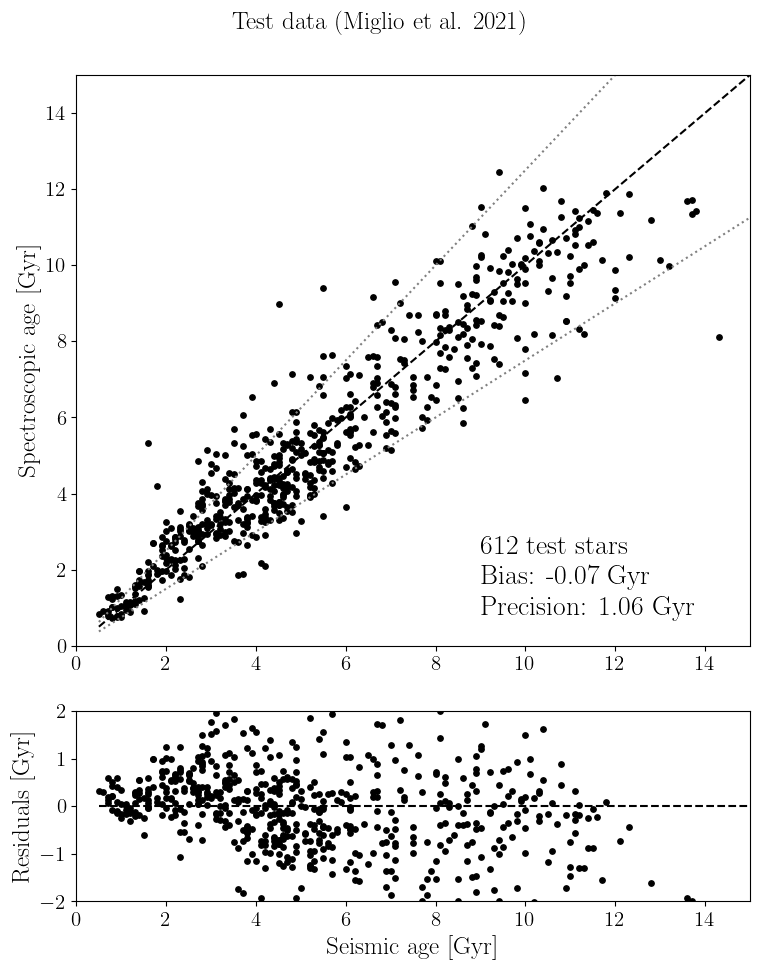

In [18]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

# Top panel: predicted age vs. seismic age
plt.axes(a0)
a0.scatter(test_y, pred, c="k", s=15, label="Default model")
#overplot_trend(test_y, pred, alpha=0.2, color="k", bins=15)
xx = np.linspace(np.min(test_y), 15, 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
a0.axis([0,15,0,15])

plt.text(9, 2.4, str(len(test_y))+ " test stars", fontsize=20)
plt.text(9, 1.6, "Bias: "+ str(np.round(np.mean(pred-test_y),2))+ " Gyr", fontsize=20)
plt.text(9, 0.8, "Precision: "+ str(np.round(np.std(pred-test_y),2))+ " Gyr", fontsize=20)

# Bottom panel: residuals
plt.axes(a1)
a1.scatter(test_y, pred-test_y, c="k", s=15)
#overplot_trend(test_y, pred-test_y, alpha=0.2, color="k", bins=15)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)
a1.axis([0,15,-2, 2])
plt.suptitle("Test data (Miglio et al. 2021)", fontsize=18)
plt.tight_layout()

# Interpreting the model - which features drive the output label most?

## Built-in feature importances (calculated through decision trees)

In [24]:
model.feature_names_in_

array(['TEFF', 'LOGG', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE',
       'AL_FE', 'SI_FE', 'K_FE', 'CA_FE', 'TI_FE', 'V_FE', 'MN_FE',
       'CO_FE', 'NI_FE', 'CE_FE'], dtype='<U5')

In [22]:
model.feature_importances_

array([0.0530684 , 0.02149347, 0.56181437, 0.01282914, 0.06841725,
       0.025723  , 0.01000998, 0.11723567, 0.01266578, 0.01374962,
       0.01162277, 0.0125755 , 0.01690895, 0.01112161, 0.01297544,
       0.01039786, 0.01375076, 0.01364033], dtype=float32)

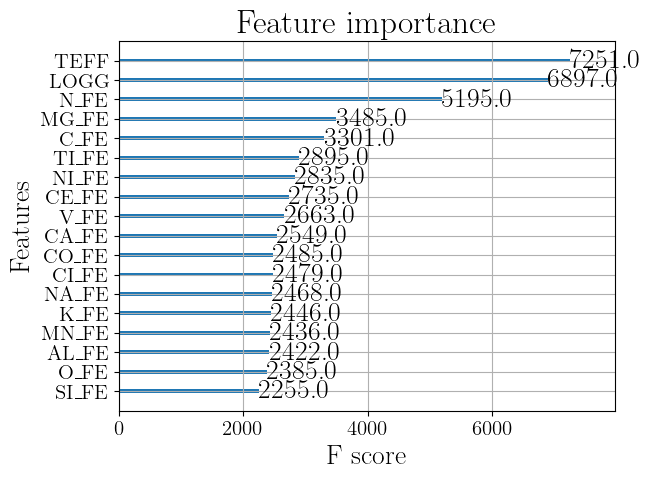

In [28]:
xgb.plot_importance(model)
plt.show()

## Optimal feature importances: SHAP


[SHAP](https://shap.readthedocs.io/en/latest/) is short for SHapley Additive exPlanations. The concept was introduced by [Lundberg & Lee (2017)](https://proceedings.neurips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html) as a unified framework for interpreting ML predictions. The authors showed that their approach has a unique solution and provides better consistency with human intuition than previous approaches.

SHAP in principle works for any supervised ML model - the website has lots of nice examples, also for [images](https://shap.readthedocs.io/en/latest/image_examples.html), [text](https://shap.readthedocs.io/en/latest/text_examples.html), etc.

In [19]:
import shap

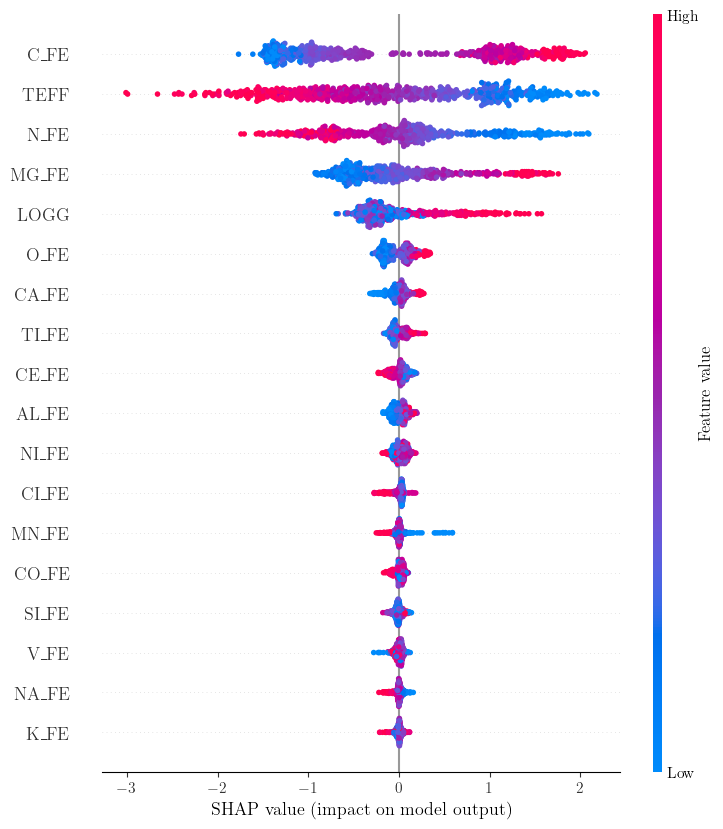

In [21]:
# Fits the explainer
explainer = shap.Explainer(model)
# Calculates the SHAP values - It might take some time
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X, show=False)
# Same as
#shap.plots.beeswarm(shap_values)

## TASK 1: Predict ages for the full APOGEE dataset

The APOGEE DR17 allStar file is big, so it's not included in the data folder. Even the "light" version is 1.7 GB:
* Data model: https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html
* "Lite" file for download: https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits

The following cell reads the DR17 table:

In [ ]:
apogee_data = "../data/allStarLite-dr17-synspec_rev1.fits"

if os.path.exists(apogee_data):
    pass
else:
    # Download the APOGEE DR17 "lite" version: (this can take a while...)
    os.system('wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits')
    os.system('mv allStarLite-dr17-synspec_rev1.fits ../data/.')

# Read and convert to pandas
apogee_dr17 = Table.read(apogee_data)
names = [name for name in apogee_dr17.colnames if len(apogee_dr17[name].shape) <= 1]
apogee_dr17.keep_columns(names)
big   = apogee_dr17.to_pandas()

print('Number of rows: ' +str(len(big)))
big.head()

In [ ]:
# filter the necessary columns:


In [ ]:
# apply the XGBoost model


In [ ]:
# plot some results


## TASK 2: Filter out unreliable results

In [ ]:
#


## TASK 3: Derive empirical uncertainty estimates

In [ ]:
# IDEA 1: Use the test dataset (see plot above)


In [ ]:
# IDEA 2: Use duplicate APOGEE observations


## TASK 4 (bonus): Reduce the number of input features

The SHAP values told us which the most important features (columns) in the age inference are. 

What happens when you reduce the number of input columns and rerun XGBoost on the smaller dataset? Does the model improve / get worse? How much faster is the training?

## TASK 5 (bonus): Write a RGB / RC classifier

We saw above that the training set consists of RGB and RC stars. In principle, asteroseismology (e.g. from Kepler) is necessary to distinguish between these evolutionary stages in this crowded region of the Hertzsprung-Russell diagram...

Can you make a classifier that uses only spectroscopic data?